In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [98]:
def lennard_jones_potential(r, sigma: float, eps: float) -> np.ndarray:
    return 4*eps*np.power(sigma, 12)/np.power(r, 12) - 4*eps*np.power(sigma, 6)/np.power(r, 6)

def lennard_jones_force(r, sigma: float, eps: float) -> np.ndarray:
    return 24*eps*np.power(sigma, 6)/np.power(r, 7) - 48*eps*np.power(sigma, 12)/np.power(r, 13)

In [112]:
def get_r(x1, y1, x2, y2):
    return np.linalg.norm([x2-x1, y2-y1])

def get_next_x(x, v, a, dt):
    return x + v*dt + a*(dt**2/2)

def get_next_ai(x, xi, r, sigma, eps):
    return lennard_jones_force(r, sigma, eps) * (xi-x)/r

def get_next_v(v, a, a_next, dt):
    return v + (a_next+a)/2*dt

In [113]:
def get_next_x_2d(x, y, vx, vy, ax, ay, dt):
    return get_next_x(x, vx, ax, dt), get_next_x(y, vy, ay, dt)

def get_next_ai_2d(x, y, xi, yi, sigma, eps):
    r = get_r(x, y, xi, yi)
    return get_next_ai(x, xi, r, sigma, eps), get_next_ai(y, yi, r, sigma, eps)

def get_next_a_2d(x, y, xs, ys, sigma, eps):
    sum_x, sum_y = 0, 0
    for i in range(len(xs)):
        _ax, _ay = get_next_ai_2d(x, y, xs[i], ys[i], sigma, eps)
        sum_x += _ax
        sum_y += _ay
    return sum_x, sum_y

def get_next_v_2d(vx, vy, ax, ay, ax_next, ay_next, dt):
    return get_next_v(vx, ax, ax_next, dt), get_next_v(vy, ay, ay_next, dt)

In [114]:
class Particle:
    x: float
    y: float
    vx: float = 0
    vy: float = 0
    ax: float = 0
    ay: float = 0

    _x: float
    _y: float
    _vx: float = 0
    _vy: float = 0
    _ax: float = 0
    _ay: float = 0
    
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def set_coords(self, x, y):
        self._x = x
        self._y = y

    def set_v(self, vx, vy):
        self._vx = vx
        self._vy = vy

    def set_a(self, ax, ay):
        self._ax = ax
        self._ay = ay
        
    def apply(self):
        self.x = self._x
        self.y = self._y
        self.vx = self._vx
        self.vy = self._vy
        self.ax = self._ax
        self.ay = self._ay
        
    def __repr__(self):
        return f'Particle<x: {self.x}, y: {self.y}, vx: {self.vx}, vy: {self.vy}, ax: {self.ax}, ay: {self.ay}>'

In [138]:
def get_kinetic_energy(particle: Particle):
    return np.power(np.linalg.norm([particle.vx, particle.vy]), 2) / 2

def step_pair(lhs: Particle, rhs: Particle, sigma: float, eps: float, dt: float = 1):
    x, y = get_next_x_2d(lhs.x, lhs.y, lhs.vx, lhs.vy, lhs.ax, lhs.ay, dt)
    ax, ay = get_next_ai_2d(lhs.x, lhs.y, rhs.x, rhs.y, sigma, eps)
    vx, vy = get_next_v_2d(lhs.vx, lhs.vy, lhs.ax, lhs.ay, ax, ay, dt)
    r = get_r(lhs.x, lhs.y, rhs.x, rhs.y)
    
    energy_pot = lennard_jones_potential(r, sigma, eps)
    energy_kin = get_kinetic_energy(lhs)
    
    lhs.set_a(ax, ay)
    lhs.set_v(vx, vy)
    lhs.set_coords(x, y)
    
    return energy_pot, energy_kin

In [142]:
p1 = Particle(100, 100)
p2 = Particle(107, 100)

SIGMA = 1
EPS = 1
STEPS = 200
DT = 1

energy_pot, energy_kin, energy_total, r = [], [], [], []

for i in range(STEPS):
    ep1, ek1 = step_pair(p1, p2, SIGMA, EPS, DT)
    ep2, ek2 = step_pair(p2, p1, SIGMA, EPS, DT)
    
    p1.apply()
    p2.apply()
    
    energy_pot.append(ep1 + ep2)
    energy_kin.append(ek1 + ek2)
    energy_total.append(ep1 + ep2 + ek1 + ek2)
    r.append(get_r(p1.x, p1.y, p2.x, p2.y))

In [143]:
display(p1)
display(p2)

Particle<x: 100.7538751202514, y: 100.0, vx: 0.010483612196654283, vy: 0.0, ax: 0.00015503515837634175, ay: 0.0>

Particle<x: 106.2461248797486, y: 100.0, vx: -0.010483612196654283, vy: 0.0, ax: -0.00015503515837634175, ay: 0.0>

<Axes: >

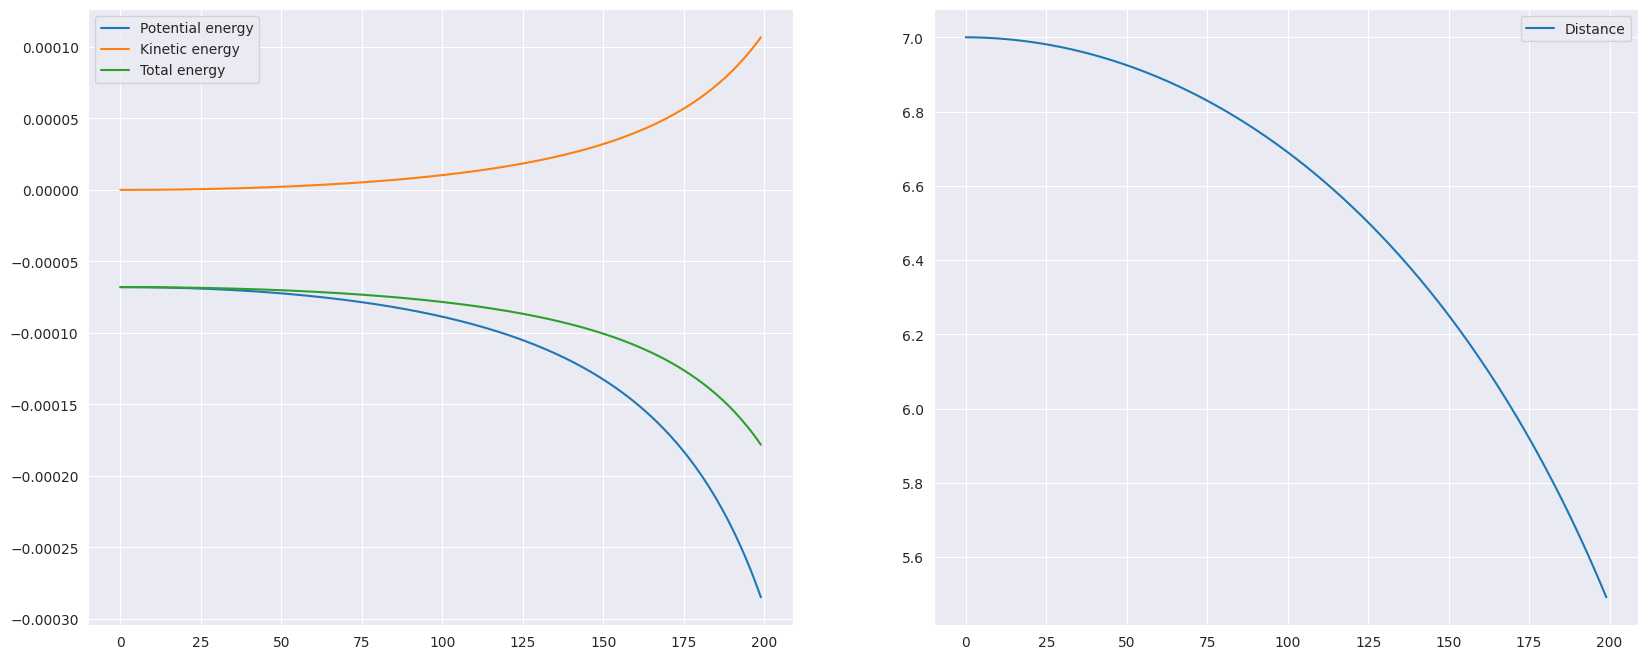

In [144]:
_, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))
t = np.arange(0, STEPS, 1)

plot = sns.lineplot(
    x=t,
    y=energy_pot,
    ax=axes[0],
    label='Potential energy',
)

sns.lineplot(
    x=t,
    y=energy_kin,
    ax=axes[0],
    label='Kinetic energy',
)

sns.lineplot(
    x=t,
    y=energy_total,
    ax=axes[0],
    label='Total energy',
)

sns.lineplot(
    x=t,
    y=r,
    ax=axes[1],
    label='Distance',
)
# plot.axhline(y=0, color='grey');